## Import Required Libraries

We'll import all necessary Python libraries for financial data analysis, portfolio optimization, and visualization.

In [ ]:
# Core data manipulation and analysis
import pandas as pd
import numpy as np
import warnings
import json

warnings.filterwarnings('ignore')

# Financial data fetching
from CourseBacktest.helpers import get_yahoo_data,create_resampled_datasets
from CourseBacktest.BacktestFramework import QuintileStrategy,GMVPStrategy,MarkowitzStrategy,EqualWeightStrategy,BacktraderPortfolioBacktest

# Performance analytics
from scipy import stats
import quantstats as qs

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Date handling
from datetime import datetime, timedelta
import random

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
#source = "yahoo"
source = "local"

## Data Loading and Preparation

We'll load S&P 500 stock data and prepare it for portfolio analysis.

In [3]:
# S&P 500 symbols (top 50 for demonstration)
SP500_symbols = [
    'AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'TSLA', 'GOOG', 'BRK-B', 'UNH', 'XOM',
    'META', 'JNJ', 'JPM', 'V', 'PG', 'AVGO', 'HD', 'CVX', 'MA', 'ABBV',
    'PFE', 'BAC', 'KO', 'COST', 'WMT', 'DIS', 'TMO', 'MRK', 'ACN', 'ADBE',
    'VZ', 'WFC', 'NFLX', 'ABT', 'CRM', 'NKE', 'CSCO', 'AMD', 'CMCSA', 'DHR',
    'INTC', 'BMY', 'PM', 'TXN', 'LIN', 'QCOM', 'HON', 'UPS', 'NEE', 'RTX'
]

print(f"Number of S&P 500 symbols loaded: {len(SP500_symbols)}")
print("Sample symbols:", SP500_symbols[:10])

to_date = datetime.now()  # today

from_date = to_date - timedelta(days=10*365)  # past ten years


start_date = from_date.strftime('%Y-%m-%d')
end_date = to_date.strftime('%Y-%m-%d')
interval = '1d'  # daily frequency

"""
Download stock data from Yahoo Finance (robust to different yfinance return shapes)

Parameters:
- symbols: list of stock symbols or single symbol string
- start_date: start date for data download
- end_date: end date for data download

"""

if source == "yahoo":
    print(f"Downloading data from {start_date} to {end_date}...")

    SP500_data = get_yahoo_data(
        ticker_list=SP500_symbols,
        start_date=start_date,
        end_date=end_date,
        interval=interval
    )

    #SP500_data = SP500_data.xs('Adj Close', axis=1, level=1)[SP500_symbols].dropna()

    print(f"Downloaded data for {len(SP500_data.columns)} stocks")
    print(f"Data shape: {SP500_data.shape}")

if source == "local":
    SP500_data = pd.read_csv('SP500_data.csv', header=[0,1], index_col=0, parse_dates=True)
    print(f"Loaded local data for {len(SP500_data.columns)} stocks")
    print(f"Data shape: {SP500_data.shape}")

Number of S&P 500 symbols loaded: 50
Sample symbols: ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'TSLA', 'GOOG', 'BRK-B', 'UNH', 'XOM']
Loaded local data for 300 stocks
Data shape: (2512, 300)


In [4]:
# Save SP500_data to CSV
#SP500_data.to_csv('SP500_data.csv')
#print("SP500_data saved to SP500_data.csv")

In [5]:
# Create resampled datasets
# Ensure integer number of periods by rounding up and set seed for reproducibility

lookback_periods = np.ceil(252/4)  # 1 year
warmup_periods = np.ceil(252/2)    # 1 year
backtest_duration = 252 * 2  # 2 years
T_sample = int(np.ceil(warmup_periods + backtest_duration))  # 2.5 years -> roundup to nearest trading days

my_dataset_list = create_resampled_datasets(
    SP500_data,
    N_sample=30,
    T_sample=T_sample,
    num_datasets=2
)

for i, dataset_item in enumerate(my_dataset_list):    
    # Print the actual asset names in this dataset_item (should be 20 assets)
    print(f"Dataset {i} asset names: {list(dataset_item.columns.get_level_values(0).unique())}")
    dates_dateset = dataset_item.index
    print(f"Dataset {i} date range: {dates_dateset.min().strftime('%Y-%m-%d')} to {dates_dateset.max().strftime('%Y-%m-%d')}")

Created 2 resampled datasets
Each dataset has 30 stocks and 630 time periods
Dataset 0 asset names: ['TXN', 'JNJ', 'MA', 'PFE', 'RTX', 'XOM', 'ABT', 'PM', 'AMZN', 'HON', 'CMCSA', 'HD', 'QCOM', 'COST', 'INTC', 'GOOG', 'BMY', 'LIN', 'WFC', 'ADBE', 'MRK', 'UNH', 'BRK-B', 'BAC', 'ABBV', 'NKE', 'WMT', 'CSCO', 'META', 'UPS']
Dataset 0 date range: 2016-08-02 to 2019-02-01
Dataset 1 asset names: ['ABT', 'MA', 'BRK-B', 'GOOGL', 'INTC', 'AVGO', 'AAPL', 'CVX', 'WFC', 'CSCO', 'DIS', 'MSFT', 'QCOM', 'ABBV', 'CMCSA', 'NVDA', 'GOOG', 'UNH', 'CRM', 'ADBE', 'NKE', 'MRK', 'PM', 'META', 'HD', 'JPM', 'HON', 'JNJ', 'PFE', 'BMY']
Dataset 1 date range: 2022-12-29 to 2025-07-07


## Portfolio Strategy Definitions

We'll implement three different portfolio strategies:
1. **Quintile Portfolio**: Invests in top 20% performing stocks
2. **GMVP**: Global Minimum Variance Portfolio 
3. **Markowitz**: Mean-variance optimized portfolio

In [ ]:
# Test the quintile portfolio function with sample data
from CourseBacktest.weights_calculators import quintile_portfolio_fun
print("Testing portfolio functions...")
sample_dataset = my_dataset_list[0]
quintile_weights = quintile_portfolio_fun(sample_dataset,base_column="Adj Close")

print(f"\\nQuintile portfolio weights sum: {quintile_weights.sum():.4f}")
print(f"\\nNumber of non-zero weights: {np.sum(quintile_weights > 0)}")

print("Quintile Weights:")
print(sample_dataset.columns.levels[0].to_list())
print(np.round(quintile_weights, 2))

Testing portfolio functions...
\nQuintile portfolio weights sum: 1.0000
\nNumber of non-zero weights: 6
Quintile Weights:
['AAPL', 'ABBV', 'ABT', 'ACN', 'ADBE', 'AMD', 'AMZN', 'AVGO', 'BAC', 'BMY', 'BRK-B', 'CMCSA', 'COST', 'CRM', 'CSCO', 'CVX', 'DHR', 'DIS', 'GOOG', 'GOOGL', 'HD', 'HON', 'INTC', 'JNJ', 'JPM', 'KO', 'LIN', 'MA', 'META', 'MRK', 'MSFT', 'NEE', 'NFLX', 'NKE', 'NVDA', 'PFE', 'PG', 'PM', 'QCOM', 'RTX', 'TMO', 'TSLA', 'TXN', 'UNH', 'UPS', 'V', 'VZ', 'WFC', 'WMT', 'XOM']
[0.   0.   0.17 0.   0.   0.   0.17 0.   0.17 0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.17 0.   0.17 0.   0.17 0.   0.   0.   0.
 0.   0.  ]


In [ ]:
# Test the Global Minimum Variance Portfolio (GMVP) function with sample data
from CourseBacktest.weights_calculators import gmvp_portfolio_fun

print("Testing portfolio functions...")
sample_dataset = my_dataset_list[0]

gmvp_weights = gmvp_portfolio_fun(sample_dataset,base_column="Adj Close")

print(f"GMVP weights sum: {gmvp_weights.sum():.4f}")
print(f"\\nNumber of non-zero weights: {np.sum(gmvp_weights > 0.001)}")
print("GMVP Weights:")
print(sample_dataset.columns.levels[0].to_list())
print(np.round(gmvp_weights, 3))


Testing portfolio functions...
GMVP weights sum: 1.0000
\nNumber of non-zero weights: 29
GMVP Weights:
['AAPL', 'ABBV', 'ABT', 'ACN', 'ADBE', 'AMD', 'AMZN', 'AVGO', 'BAC', 'BMY', 'BRK-B', 'CMCSA', 'COST', 'CRM', 'CSCO', 'CVX', 'DHR', 'DIS', 'GOOG', 'GOOGL', 'HD', 'HON', 'INTC', 'JNJ', 'JPM', 'KO', 'LIN', 'MA', 'META', 'MRK', 'MSFT', 'NEE', 'NFLX', 'NKE', 'NVDA', 'PFE', 'PG', 'PM', 'QCOM', 'RTX', 'TMO', 'TSLA', 'TXN', 'UNH', 'UPS', 'V', 'VZ', 'WFC', 'WMT', 'XOM']
[0.002 0.073 0.009 0.035 0.021 0.073 0.011 0.069 0.001 0.093 0.02  0.03
 0.004 0.035 0.008 0.002 0.033 0.038 0.049 0.03  0.058 0.034 0.066 0.003
 0.038 0.018 0.06  0.055 0.027 0.003]


In [ ]:
#Test the Markowitz portfolio function with sample data
from CourseBacktest.weights_calculators import markowitz_portfolio_fun

print("Testing portfolio functions...")
sample_dataset = my_dataset_list[1]

markowitz_weights = markowitz_portfolio_fun(sample_dataset,base_column="Adj Close")

print(f"Markowitz weights sum: {markowitz_weights.sum():.4f}")
print(f"\\nNumber of non-zero weights: {np.sum(markowitz_weights > 0.001)}")
print("Markowitz Weights:")
print(sample_dataset.columns.levels[0].to_list())
print(np.round(markowitz_weights*100, 3))


Testing portfolio functions...
Markowitz weights sum: 1.0000
\nNumber of non-zero weights: 1
Markowitz Weights:
['AAPL', 'ABBV', 'ABT', 'ACN', 'ADBE', 'AMD', 'AMZN', 'AVGO', 'BAC', 'BMY', 'BRK-B', 'CMCSA', 'COST', 'CRM', 'CSCO', 'CVX', 'DHR', 'DIS', 'GOOG', 'GOOGL', 'HD', 'HON', 'INTC', 'JNJ', 'JPM', 'KO', 'LIN', 'MA', 'META', 'MRK', 'MSFT', 'NEE', 'NFLX', 'NKE', 'NVDA', 'PFE', 'PG', 'PM', 'QCOM', 'RTX', 'TMO', 'TSLA', 'TXN', 'UNH', 'UPS', 'V', 'VZ', 'WFC', 'WMT', 'XOM']
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0. 100.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.]


## Different Portfolios Backtesting

We'll implement a comprehensive backtesting framework that includes:
- Portfolio rebalancing at specified intervals
- Benchmark portfolios (1/N and index)
- Performance metrics calculation
- Transaction costs simulation


### Parameters:
- `warmup_periods`: Number of periods to skip (default: same as `lookback`)
- `lookback`: Historical data window for portfolio calculations
- `rebalance_every`: Frequency of portfolio rebalancing

This ensures that when portfolio optimization functions (like Markowitz, GMVP) are called, they have the required historical data for meaningful calculations.

In [9]:
# Run the backtrader backtesting with warmup period handling
# Ensure numeric parameters are ints to avoid float indexing errors

# Initialize strategy dictionary for backtrader
bt_portfolios = {
    "Quintile": QuintileStrategy,
    "GMVP": GMVPStrategy,
    "Markowitz": MarkowitzStrategy
}

bt_backtest = BacktraderPortfolioBacktest(
    portfolios=bt_portfolios, 
    datasets=my_dataset_list,
    benchmark=['1/N'],
    rebalance_every=int(21),  # Rebalance every month
    lookback=int(lookback_periods),     # 4 months lookback for calculations (cast to int)
    initial_cash=100000.0,
    commission=0.001  # 0.1% commission
)

# Run the backtest
backtest_results = bt_backtest.run_backtest()

print("\nBacktrader backtesting with warmup period completed successfully!")
print(f"Lookback period: {bt_backtest.lookback} days")
print(f"Rebalancing frequency: {bt_backtest.rebalance_every} days")

Starting backtrader portfolio backtesting...
Backtesting Quintile on 1...
2016-08-29, Warmup period: 20/63 bars
2016-09-27, Warmup period: 40/63 bars
2016-10-25, Warmup period: 60/63 bars
2016-10-28, Warmup period complete. Starting trading with 63 bars of data.
2016-10-31, Cash constraint: allocated 120 of 127 desired shares for META.
2016-11-01, BUY EXECUTED: MA, Size: 155, Price: 107.00, Total Cost: 16585.00, Comm 16.59
2016-11-01, BUY EXECUTED: QCOM, Size: 242, Price: 69.00, Total Cost: 16698.00, Comm 16.70
2016-11-01, BUY EXECUTED: GOOG, Size: 424, Price: 39.14, Total Cost: 16597.27, Comm 16.60
2016-11-01, BUY EXECUTED: ADBE, Size: 155, Price: 107.79, Total Cost: 16707.45, Comm 16.71
2016-11-01, BUY EXECUTED: BAC, Size: 1010, Price: 16.56, Total Cost: 16725.60, Comm 16.73
2016-11-01, BUY EXECUTED: META, Size: 120, Price: 131.41, Total Cost: 15769.20, Comm 15.77
2016-11-30, Cash constraint: allocated 139 of 144 desired shares for UPS.
2016-12-01, SELL EXECUTED: QCOM, Size: -242, Pr

In [10]:
# Convert numpy arrays and other non-serializable objects to serializable types
def make_serializable(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, pd.DataFrame):
        return obj.to_dict()
    elif isinstance(obj, pd.Series):
        return obj.to_dict()
    elif isinstance(obj, (np.float64, np.float32, np.int64, np.int32)):
        return obj.item()
    elif isinstance(obj, (datetime, pd.Timestamp)):
        return obj.strftime('%Y-%m-%d')
    elif hasattr(obj, 'strftime'):  # This catches datetime.date and other date-like objects
        return obj.strftime('%Y-%m-%d')
    elif isinstance(obj, (list, dict, str, int, float, bool)) or obj is None:
        return obj
    else:
        return type(obj).__name__ 

def recursive_serialize(data):
    if isinstance(data, dict):
        return {k: recursive_serialize(v) for k, v in data.items()}
    elif isinstance(data, list):
        return [recursive_serialize(v) for v in data]
    else:
        return make_serializable(data)

serializable_results = recursive_serialize(backtest_results)

with open('backtest_results.json', 'w') as f:
    json.dump(serializable_results, f, indent=2)

In [11]:
# Extract return dates and returns per strategy/dataset from bt_backtest.results
def extract_returns_by_strategy(bt_backtest):
    results_out = {}
    
    for strat_name, datasets in bt_backtest.results.items():
        results_out[strat_name] = {}
        for ds_name, res in datasets.items():
            rets = res.get('returns', None)
            dates = res.get('return_dates', None)
            
            # Normalize returns to list
            if rets is None:
                rets_list = []
            else:
                rets_list = np.asarray(rets).tolist()
            
            # If dates missing or length mismatch, try to recover from stored dataset index
            if dates is None or len(dates) != len(rets_list):
                ds_obj = None
                if hasattr(bt_backtest, 'datasets'):
                    ds_obj = bt_backtest.datasets.get(ds_name, None)
                if ds_obj is None:
                    # fallback to empty or synthetic daily dates ending at end_date
                    if len(rets_list) > 0:
                        dates_list = pd.date_range(end=pd.to_datetime(end_date), periods=len(rets_list), freq='D').strftime('%Y-%m-%d').tolist()
                    else:
                        dates_list = []
                else:
                    idx = pd.to_datetime(ds_obj.index)
                    # If index length matches returns use it, otherwise try to align end of index to returns length
                    if len(idx) == len(rets_list):
                        dates_list = idx.strftime('%Y-%m-%d').tolist()
                    elif len(idx) >= len(rets_list) and len(rets_list) > 0:
                        # align latest returns to the tail of the dataset index
                        dates_list = idx[-len(rets_list):].strftime('%Y-%m-%d').tolist()
                    elif len(rets_list) > 0:
                        dates_list = pd.date_range(start=idx.min(), periods=len(rets_list), freq='D').strftime('%Y-%m-%d').tolist()
                    else:
                        dates_list = []
            else:
                dates_list = [pd.to_datetime(d).strftime('%Y-%m-%d') for d in dates]
            
            results_out[strat_name][ds_name] = {
                'dates': dates_list,
                'returns': rets_list
            }
    return results_out

# Run extraction and print a compact summary
returns_by_strategy = extract_returns_by_strategy(bt_backtest)

for strat, datasets in returns_by_strategy.items():
    print(f"\nStrategy: {strat}")
    for dataset_item in datasets.values():
        print(pd.DataFrame(dataset_item))


Strategy: Quintile
          dates   returns
0    2016-08-02  0.000000
1    2016-08-03  0.000000
2    2016-08-04  0.000000
3    2016-08-05  0.000000
4    2016-08-08  0.000000
..          ...       ...
625  2019-01-28 -0.014027
626  2019-01-29  0.008539
627  2019-01-30  0.003886
628  2019-01-31  0.013952
629  2019-02-01  0.010166

[630 rows x 2 columns]
          dates   returns
0    2022-12-29  0.000000
1    2022-12-30  0.000000
2    2023-01-03  0.000000
3    2023-01-04  0.000000
4    2023-01-05  0.000000
..          ...       ...
625  2025-06-30  0.009303
626  2025-07-01 -0.017932
627  2025-07-02  0.004937
628  2025-07-03  0.012844
629  2025-07-07 -0.001067

[630 rows x 2 columns]

Strategy: GMVP
          dates   returns
0    2016-08-02  0.000000
1    2016-08-03  0.000000
2    2016-08-04  0.000000
3    2016-08-05  0.000000
4    2016-08-08  0.000000
..          ...       ...
625  2019-01-28 -0.007225
626  2019-01-29 -0.000502
627  2019-01-30  0.009073
628  2019-01-31  0.009270
629  2

=== TESTING RETURN DATES FUNCTIONALITY ===

✓ Return dates successfully captured for Markowitz on dataset_1
Number of return dates: 630
Number of returns: 630

First few return dates and values:
  2016-08-02: 0.000000
  2016-08-03: 0.000000
  2016-08-04: 0.000000
  2016-08-05: 0.000000
  2016-08-08: 0.000000

Last few return dates and values:
  2019-01-30: 0.001912
  2019-01-31: 0.014445
  2019-02-01: 0.027136


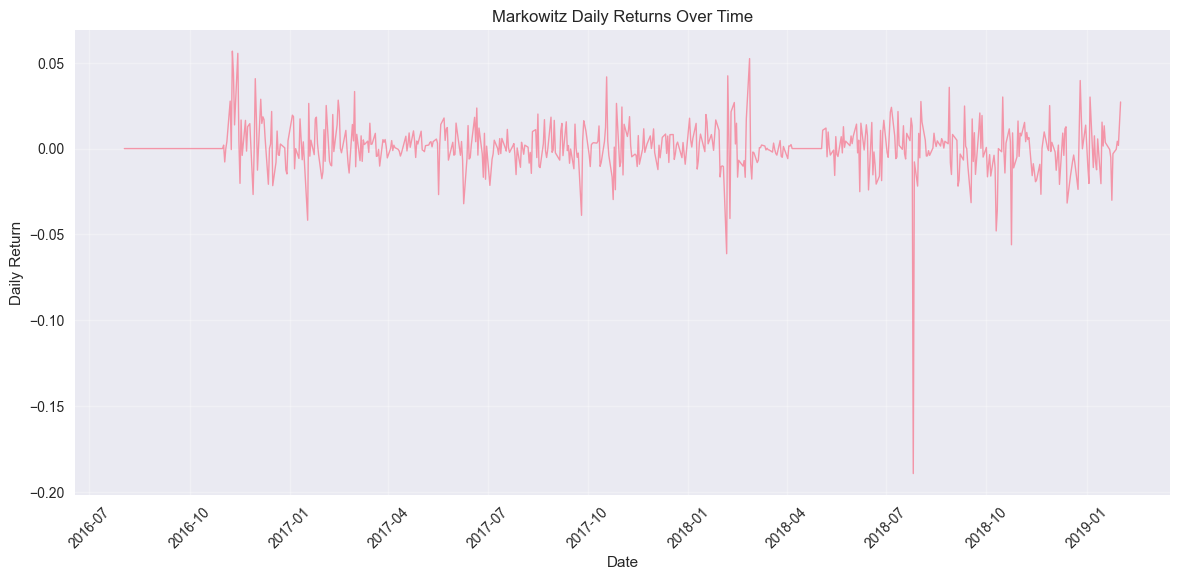


✓ Returns time series successfully created and plotted!


In [12]:
# Test the new return dates functionality
print("=== TESTING RETURN DATES FUNCTIONALITY ===\n")


strategy_name = "Markowitz"
dataset_name = "dataset_1"

result = bt_backtest.results[strategy_name][dataset_name]

# Check if we have return dates
if 'return_dates' in result:
    return_dates = result['return_dates']
    returns = result['returns']
    
    print(f"✓ Return dates successfully captured for {strategy_name} on {dataset_name}")
    print(f"Number of return dates: {len(return_dates)}")
    print(f"Number of returns: {len(returns)}")
    
    if len(return_dates) > 0 and len(returns) > 0:
        print(f"\nFirst few return dates and values:")
        for i in range(min(5, len(return_dates))):
            print(f"  {return_dates[i]}: {returns[i]:.6f}")
            
        print(f"\nLast few return dates and values:")
        for i in range(max(0, len(return_dates)-3), len(return_dates)):
            print(f"  {return_dates[i]}: {returns[i]:.6f}")
            
        # Create a quick time series plot
        returns_df = pd.DataFrame({
            'Date': pd.to_datetime(return_dates),
            'Returns': returns
        }).set_index('Date')
        
        plt.figure(figsize=(12, 6))
        plt.plot(returns_df.index, returns_df['Returns'], linewidth=1, alpha=0.7)
        plt.title(f'{strategy_name} Daily Returns Over Time')
        plt.xlabel('Date')
        plt.ylabel('Daily Return')
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        print(f"\n✓ Returns time series successfully created and plotted!")
    else:
        print("⚠ No return data available for plotting")
else:
    print("⚠ Return dates not found in results - check BacktestFramework implementation")

In [13]:
# Print rebalancing dates and weights as a table (new cell at index 18)

# Choose strategy/dataset (adjust if you want a different one)
strategy = strategy_name if strategy_name in bt_backtest.results else (list(bt_backtest.results.keys())[0] if len(bt_backtest.results)>0 else None)
dataset = dataset_name if 'dataset_name' in globals() else 'dataset_1'

if strategy is None:
    print("No strategies available in bt_backtest.results")
else:
    res = bt_backtest.results.get(strategy, {}).get(dataset, {})
    weights_history = res.get('weights_history', {})

    if not weights_history:
        print(f"No weights_history found for strategy '{strategy}' and dataset '{dataset}'")
    else:
        # Extract components
        dates = weights_history.get('rebalancing_dates', [])
        weights = weights_history.get('portfolio_weights', [])
        asset_names = weights_history.get('asset_names', [])

        # Normalize asset_names (handle nested lists)
        if len(asset_names) == 0:
            columns = [f'asset_{i}' for i in range(len(weights[0]) if len(weights)>0 else 0)]
        else:
            first = asset_names[0]
            if isinstance(first, (list, tuple, np.ndarray)):
                columns = list(first)
            else:
                columns = list(asset_names)

        # Build DataFrame
        try:
            idx = pd.to_datetime(dates)
        except Exception:
            idx = dates

        weights_df = pd.DataFrame(list(weights), index=idx, columns=columns)

        # If many assets, show top by average weight by default
        max_assets_to_show = 20
        if weights_df.shape[1] > max_assets_to_show:
            avg_w = weights_df.mean().sort_values(ascending=False)
            top_assets = avg_w.head(max_assets_to_show).index.tolist()
            display_df = weights_df[top_assets]
            print(f"Showing top {max_assets_to_show} assets by average weight (of {weights_df.shape[1]} total assets).")
        else:
            display_df = weights_df

        # Format as percentages for readability
        display_df_pct = (display_df * 100).round(3).fillna(0).astype(str) + '%'

        # Print compact table
        print(f"\nRebalancing dates and weights for strategy='{strategy}', dataset='{dataset}':\n")
        display(display_df_pct)

Showing top 20 assets by average weight (of 30 total assets).

Rebalancing dates and weights for strategy='Markowitz', dataset='dataset_1':



,ADBE,BAC,QCOM,AMZN,ABBV,MRK,WMT,META,PM,ABT,LIN,UNH,NKE,MA,INTC,JNJ,COST,BRK-B,CMCSA,BMY
2016-10-31,0.0%,100.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
2016-11-30,0.0%,100.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
2016-12-30,0.0%,100.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
2017-02-01,0.0%,100.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
2017-03-03,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,100.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
2017-04-03,100.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
2017-05-03,100.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
2017-06-02,100.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
2017-07-03,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,74.878%,25.122%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
2017-08-02,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,100.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%


## Performance Analysis and Visualization

Let's analyze the performance of our portfolio strategies and create visualizations.

In [14]:
# Performance Analysis Functions (Updated for Backtrader)

def display_bt_portfolio_performance(bt_results, portfolio_names, measures=['Sharpe ratio', 'max drawdown']):
    """Display performance metrics for selected portfolios (backtrader version)"""
    
    performance_data = []
    
    for portfolio_name in portfolio_names:
        if portfolio_name in bt_results.results:
            for dataset_name in bt_results.results[portfolio_name].keys():
                row = {'Portfolio': portfolio_name, 'Dataset': dataset_name}
                for measure in measures:
                    # Safely fetch measure, coerce None to np.nan for numeric operations
                    val = bt_results.results[portfolio_name][dataset_name]['performance'].get(measure, None)
                    if val is None:
                        row[measure] = np.nan
                    else:
                        try:
                            row[measure] = float(val)
                        except Exception:
                            row[measure] = np.nan
                performance_data.append(row)
    
    df = pd.DataFrame(performance_data)
    # Ensure numeric columns are proper dtype
    for m in measures:
        if m in df.columns:
            df[m] = pd.to_numeric(df[m], errors='coerce')
    return df

def create_bt_summary_table(bt_results, summary_fun='median'):
    """Create summary statistics table (backtrader version)"""
    
    strategies = list(bt_results.results.keys())
    if len(strategies) == 0:
        return pd.DataFrame()
        
    # Get available metrics from first strategy/dataset
    first_strategy = strategies[0]
    first_dataset = list(bt_results.results[first_strategy].keys())[0]
    measures = list(bt_results.results[first_strategy][first_dataset]['performance'].keys())
    
    summary_data = []
    
    for strategy in strategies:
        row = {'Portfolio': strategy}
        
        for measure in measures:
            values = []
            for dataset in bt_results.results[strategy].keys():
                val = bt_results.results[strategy][dataset]['performance'].get(measure, None)
                # keep only numeric, non-NaN values
                if val is None:
                    continue
                try:
                    v = float(val)
                    if np.isnan(v):
                        continue
                    values.append(v)
                except Exception:
                    continue
            
            if len(values) > 0:
                if summary_fun == 'median':
                    row[measure] = float(np.median(values))
                elif summary_fun == 'mean':
                    row[measure] = float(np.mean(values))
                elif summary_fun == 'std':
                    row[measure] = float(np.std(values))
                else:
                    row[measure] = float(np.median(values))
            else:
                # fallback to NaN when no numeric values available
                row[measure] = np.nan
        
        summary_data.append(row)
    
    return pd.DataFrame(summary_data)

# Display individual portfolio performance
print("=== BACKTRADER PORTFOLIO PERFORMANCE ===\\n")

available_strategies = list(bt_backtest.results.keys())
for portfolio_name in available_strategies:
    if portfolio_name in bt_backtest.results:
        perf_df = display_bt_portfolio_performance(bt_backtest, [portfolio_name], ['Sharpe ratio', 'max drawdown'])
        if len(perf_df) > 0:
            # Use pandas mean which ignores NaN values
            avg_sharpe = perf_df['Sharpe ratio'].mean() if 'Sharpe ratio' in perf_df.columns else np.nan
            avg_dd = perf_df['max drawdown'].mean() if 'max drawdown' in perf_df.columns else np.nan
            print(f"{portfolio_name} Portfolio Performance:")
            print(f"Average Sharpe Ratio: {avg_sharpe:.4f}")
            print(f"Average Max Drawdown: {avg_dd:.4f}")
            print()

# Create comprehensive summary table
print("=== BACKTRADER PERFORMANCE SUMMARY TABLE ===")
bt_summary_df = create_bt_summary_table(bt_backtest, summary_fun='median')
if len(bt_summary_df) > 0:
    bt_summary_df = bt_summary_df.round(4)
    
    # Sort by Sharpe ratio if available and not all-NaN
    if 'Sharpe ratio' in bt_summary_df.columns:
        # Replace NaN temporarily to allow sorting (NaN -> -inf so they appear last)
        bt_summary_df['_sort_sharpe'] = bt_summary_df['Sharpe ratio'].fillna(-np.inf)
        bt_summary_df = bt_summary_df.sort_values('_sort_sharpe', ascending=False).drop(columns=['_sort_sharpe'])
    print(bt_summary_df.to_string(index=False))
else:
    print("No results available for summary table.")

=== BACKTRADER PORTFOLIO PERFORMANCE ===\n
Quintile Portfolio Performance:
Average Sharpe Ratio: 0.4763
Average Max Drawdown: 0.2513

GMVP Portfolio Performance:
Average Sharpe Ratio: 0.8158
Average Max Drawdown: 0.1782

Markowitz Portfolio Performance:
Average Sharpe Ratio: 0.3534
Average Max Drawdown: 0.4221

1/N Portfolio Performance:
Average Sharpe Ratio: 0.9376
Average Max Drawdown: 0.1726

=== BACKTRADER PERFORMANCE SUMMARY TABLE ===
Portfolio  Sharpe ratio  max drawdown  annual return  annual volatility  VaR (5%)  skewness  kurtosis
      1/N        0.9376        0.1726         0.1488             0.1320   -0.0126    0.0592   12.8340
     GMVP        0.8158        0.1782         0.1300             0.1361   -0.0130   -0.0862   10.2095
 Quintile        0.4763        0.2513         0.1013             0.1836   -0.0183   -0.4065    3.7879
Markowitz        0.3534        0.4221         0.1096             0.2882   -0.0256   -2.0104   26.3820


Creating backtrader performance visualizations...\n


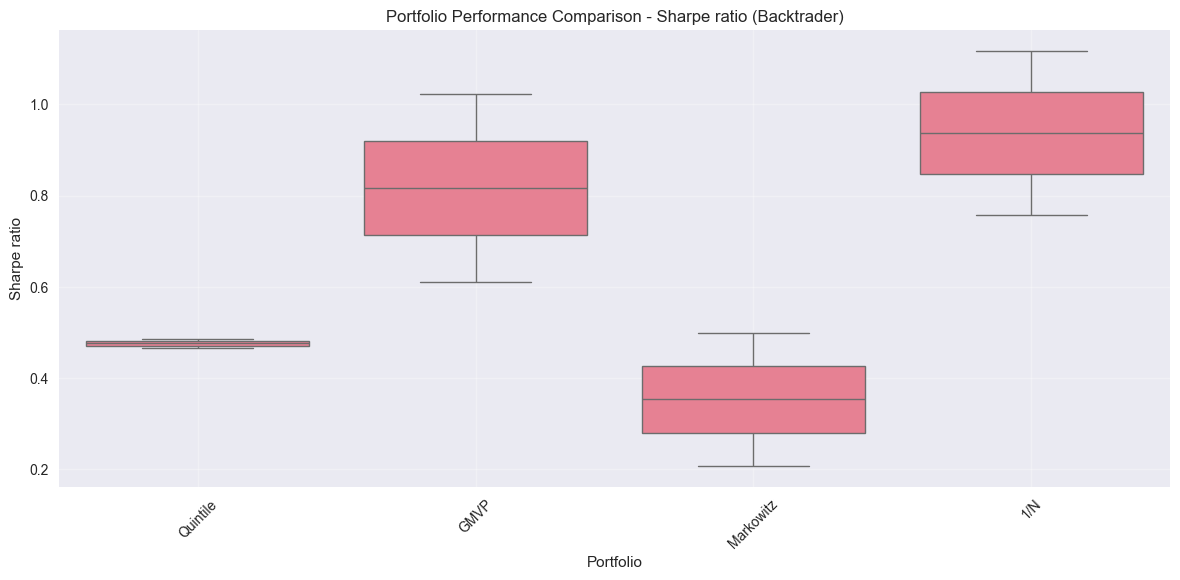

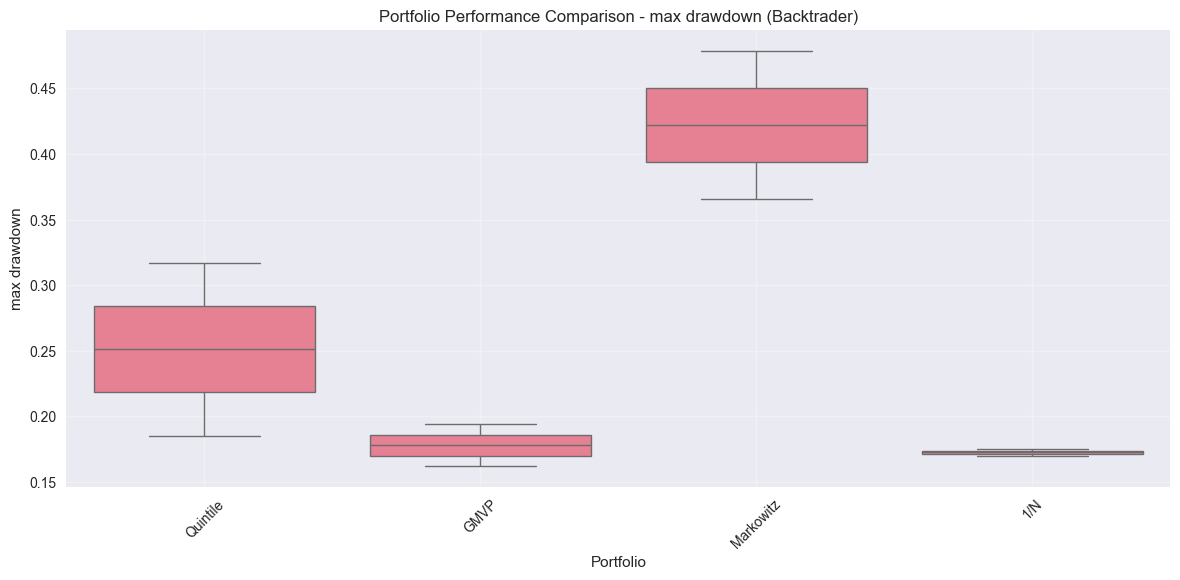

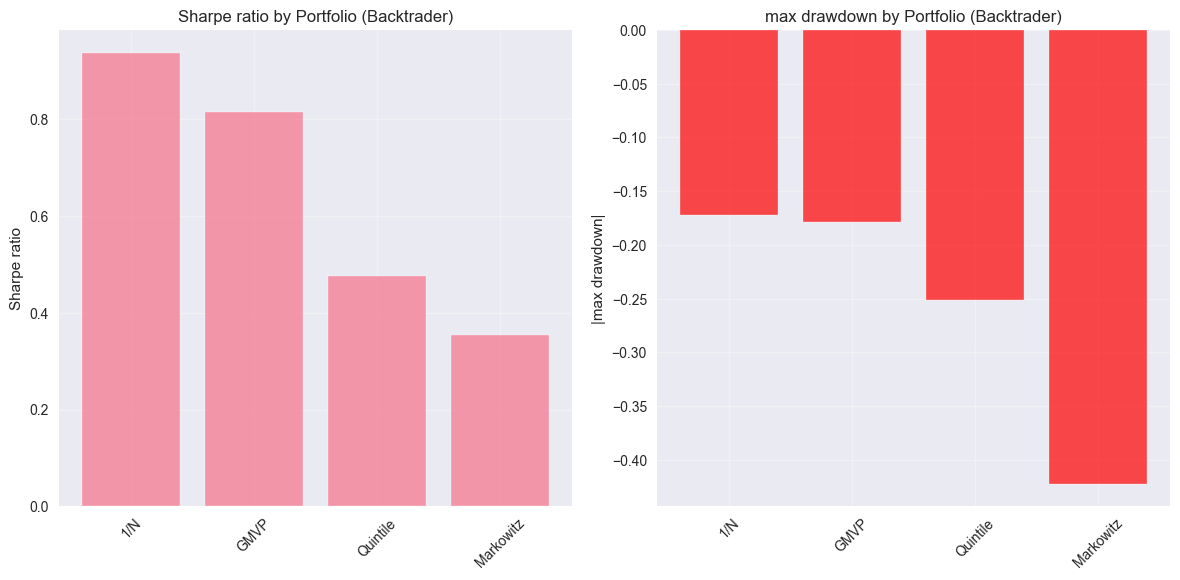

In [15]:
# Visualization Functions (Updated for Backtrader)

def plot_bt_performance_comparison(bt_results, measure='Sharpe ratio'):
    """Create box plot comparing portfolio performance (backtrader version)"""
    
    strategies = list(bt_results.results.keys())
    data_for_plot = []
    
    for strategy in strategies:
        values = []
        for dataset in bt_results.results[strategy].keys():
            if measure in bt_results.results[strategy][dataset]['performance']:
                values.append(bt_results.results[strategy][dataset]['performance'][measure])
        
        for val in values:
            data_for_plot.append({'Portfolio': strategy, measure: val})
    
    if len(data_for_plot) == 0:
        print(f"No data available for {measure}")
        return
        
    df_plot = pd.DataFrame(data_for_plot)
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_plot, x='Portfolio', y=measure)
    plt.title(f'Portfolio Performance Comparison - {measure} (Backtrader)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_bt_summary_barplot(summary_df, measures=['Sharpe ratio', 'max drawdown']):
    """Create bar plot for summary performance measures (backtrader version)"""
    
    if len(summary_df) == 0:
        print("No summary data available for plotting")
        return
    
    available_measures = [m for m in measures if m in summary_df.columns]
    n_measures = len(available_measures)
    
    if n_measures == 0:
        print("No requested measures available in summary data")
        return
    
    fig, axes = plt.subplots(1, n_measures, figsize=(6*n_measures, 6))
    
    if n_measures == 1:
        axes = [axes]
    
    for i, measure in enumerate(available_measures):
        ax = axes[i]
        
        if measure == 'max drawdown':
            # For max drawdown, we want to show absolute values (less negative is better)
            ax.bar(summary_df['Portfolio'], -summary_df[measure], color='red', alpha=0.7)
            ax.set_ylabel(f'|{measure}|')
        else:
            ax.bar(summary_df['Portfolio'], summary_df[measure], alpha=0.7)
            ax.set_ylabel(measure)
        
        ax.set_title(f'{measure} by Portfolio (Backtrader)')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


# Create visualizations if we have results
if len(bt_backtest.results) > 0:
    print("Creating backtrader performance visualizations...\\n")
    
    # 1. Box plot for Sharpe ratio comparison
    plot_bt_performance_comparison(bt_backtest, 'Sharpe ratio')
    
    # 2. Box plot for Max Drawdown comparison  
    plot_bt_performance_comparison(bt_backtest, 'max drawdown')
    
    # 3. Summary bar plots
    if len(bt_summary_df) > 0:
        plot_bt_summary_barplot(bt_summary_df, ['Sharpe ratio', 'max drawdown'])    
else:
    print("No backtrader results available for visualization")

In [16]:
def plot_bt_cumulative_returns(bt_results, strategies_to_plot, dataset_num=1):
    """Plot cumulative returns for selected strategies on a specific dataset (backtrader version)"""

    dataset_name = f'dataset_{dataset_num}'

    fig = go.Figure()
    
    for strategy_name in strategies_to_plot:
        print(f"Plotting {strategy_name} on {dataset_name}...")
        if strategy_name in bt_results.results and dataset_name in bt_results.results[strategy_name]:
            returns = bt_results.results[strategy_name][dataset_name]['returns']
            return_dates = bt_results.results[strategy_name][dataset_name].get('return_dates', [])
            
            print(f"Plotting {strategy_name} on {dataset_name} with {len(returns)} return points")
            if len(returns) > 0:
                cumulative_returns = (1 + pd.Series(returns)).cumprod()
                
                # Use actual return dates if available, otherwise create synthetic dates
                if len(return_dates) == len(returns):
                    dates = pd.to_datetime(return_dates)
                    print(f"  Using actual return dates from {dates[0]} to {dates[-1]}")
                else:
                    dates = pd.date_range(start='2022-01-01', periods=len(cumulative_returns), freq='D')
                    print(f"  Using synthetic dates (actual dates not available)")
                
                fig.add_trace(go.Scatter(
                    x=dates, 
                    y=cumulative_returns,
                    mode='lines',
                    name=strategy_name,
                    line=dict(width=2)
                ))
    
    fig.update_layout(
        title=f'Cumulative Returns - {dataset_name} (Backtrader)',
        xaxis_title='Date',
        yaxis_title='Cumulative Return',
        height=600,
        showlegend=True,
        xaxis_showgrid=True,
        yaxis_showgrid=True
    )
    
    fig.show()

# 4. Cumulative returns plot
available_strategies = list(bt_backtest.results.keys())
plot_bt_cumulative_returns(bt_backtest, available_strategies, dataset_num=2)

Plotting Quintile on dataset_2...
Plotting Quintile on dataset_2 with 630 return points
  Using actual return dates from 2022-12-29 00:00:00 to 2025-07-07 00:00:00
Plotting GMVP on dataset_2...
Plotting GMVP on dataset_2 with 630 return points
  Using actual return dates from 2022-12-29 00:00:00 to 2025-07-07 00:00:00
Plotting Markowitz on dataset_2...
Plotting Markowitz on dataset_2 with 630 return points
  Using actual return dates from 2022-12-29 00:00:00 to 2025-07-07 00:00:00
Plotting 1/N on dataset_2...
Plotting 1/N on dataset_2 with 630 return points
  Using actual return dates from 2022-12-29 00:00:00 to 2025-07-07 00:00:00


Creating backtrader additional visualizations...\n


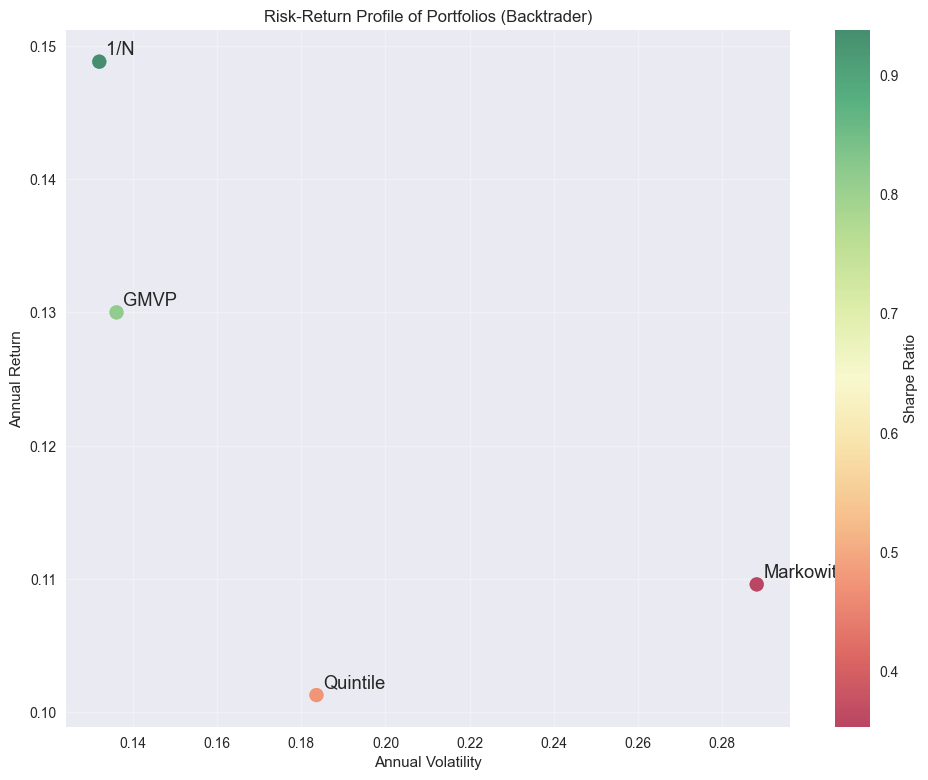

In [18]:
# Portfolio Allocation Visualization (Updated for Backtrader)

def plot_bt_portfolio_weights(bt_results, strategy_name, dataset_num=1, max_assets=10):
    """Plot portfolio weight evolution over time (backtrader version)"""
    
    dataset_name = f'dataset {dataset_num}'
    
    if strategy_name in bt_results.results and dataset_name in bt_results.results[strategy_name]:
        strategy_result = bt_results.results[strategy_name][dataset_name]
        
        # Get the strategy object to access weight information
        strategy_obj = strategy_result.get('strategy')
        if strategy_obj is None:
            print(f"No strategy object available for {strategy_name} on {dataset_name}")
            return
            
        # For now, we'll use the dataset asset names for demonstration
        # In a full implementation, you'd store weight history in the strategy
        dataset = bt_results.datasets[dataset_name]
        asset_names = list(dataset['adjusted'].columns[:max_assets])
        
        # Create mock weight evolution (this would need to be stored during backtesting)
        print(f"\\nWeight visualization for {strategy_name} strategy on {dataset_name}:")
        print("Note: Full weight tracking would require storing weight history in the strategy.")
        print(f"Strategy trades on assets: {asset_names}")
        
        # Show final portfolio value and basic info
        final_value = strategy_result['final_value']
        initial_value = bt_results.initial_cash
        total_return = (final_value / initial_value - 1) * 100
        
        print(f"Final Portfolio Value: ${final_value:,.2f}")
        print(f"Total Return: {total_return:.2f}%")
        
        # For demonstration, create a simple bar chart showing equal representation
        n_assets = len(asset_names)
        mock_weights = np.ones(n_assets) / n_assets
        
        plt.figure(figsize=(12, 6))
        plt.bar(asset_names, mock_weights)
        plt.title(f'{strategy_name} Strategy - Asset Allocation ({dataset_name})')
        plt.xlabel('Assets')
        plt.ylabel('Weight (Mock Equal Weight)')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

def create_bt_risk_return_scatter(summary_df):
    """Create risk-return scatter plot (backtrader version)"""
    
    if len(summary_df) == 0 or 'annual volatility' not in summary_df.columns or 'annual return' not in summary_df.columns:
        print("Insufficient data for risk-return scatter plot")
        return
    
    plt.figure(figsize=(10, 8))
    
    # Check if Sharpe ratio is available for color coding
    if 'Sharpe ratio' in summary_df.columns:
        scatter = plt.scatter(summary_df['annual volatility'], 
                             summary_df['annual return'],
                             s=100, alpha=0.7, c=summary_df['Sharpe ratio'], 
                             cmap='RdYlGn')
        plt.colorbar(scatter, label='Sharpe Ratio')
    else:
        plt.scatter(summary_df['annual volatility'], 
                   summary_df['annual return'],
                   s=100, alpha=0.7)
    
    # Add portfolio labels
    for i, portfolio in enumerate(summary_df['Portfolio']):
        plt.annotate(portfolio, 
                    (summary_df['annual volatility'].iloc[i], 
                     summary_df['annual return'].iloc[i]),
                    xytext=(5, 5), textcoords='offset points')
    
    plt.xlabel('Annual Volatility')
    plt.ylabel('Annual Return')
    plt.title('Risk-Return Profile of Portfolios (Backtrader)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Create additional visualizations if we have results
if len(bt_backtest.results) > 0:
    print("Creating backtrader additional visualizations...\\n")
    
    available_strategies = list(bt_backtest.results.keys())
    
    # Plot portfolio weights for available strategies
    for strategy_name in available_strategies[:2]:  # Limit to first 2 strategies
        plot_bt_portfolio_weights(bt_backtest, strategy_name, dataset_num=1)
    
    # Risk-return scatter plot
    if len(bt_summary_df) > 0:
        create_bt_risk_return_scatter(bt_summary_df)

else:
    print("No backtrader results available for additional visualizations")

## Testing Portfolio Weights Analyzer

Let's test our new PortfolioWeightsAnalyzer to verify it correctly tracks rebalancing dates and portfolio weights.

In [22]:
analyze_strategy = "Markowitz"
dataset_num = 2

# Examine the weights history  strategy on dataset
if analyze_strategy in bt_backtest.results and f'dataset_{dataset_num}' in bt_backtest.results[analyze_strategy]:
    result = bt_backtest.results[analyze_strategy][f'dataset_{dataset_num}']
    weights_data = result.get('weights_history', {})
    
    print(f"\\n=== {analyze_strategy} STRATEGY WEIGHTS TRACKING RESULTS ===")
    print(f"Final portfolio value: ${result['final_value']:,.2f}")
    print(f"Number of rebalancing events: {len(weights_data.get('rebalancing_dates', []))}")
    
    if len(weights_data.get('rebalancing_dates', [])) > 0:
        print(f"\\nSuccessfully tracked {len(weights_data['rebalancing_dates'])} rebalancing events!")
        print(f"\\nFirst rebalancing event:")
        
        date = weights_data['rebalancing_dates'][0]
        weights = weights_data['portfolio_weights'][0]
        assets = weights_data['asset_names'][0]
        
        print(f"Date: {date}")
        print(f"Number of assets: {len(assets)}")
        print(f"Weights sum: {sum(weights):.4f}")
        print(f"Non-zero weights: {sum(1 for w in weights if w > 0.001)}")
        
        # Show top 3 weights
        weight_pairs = list(zip(assets, weights))
        weight_pairs.sort(key=lambda x: x[1], reverse=True)
        print("\\nTop 3 asset weights:")
        for j in range(min(3, len(weight_pairs))):
            asset, weight = weight_pairs[j]
            print(f"  {asset}: {weight:.4f} ({weight*100:.2f}%)")
            
        print("\\n✓ Portfolio Weights Analyzer is working correctly!")
    else:
        print("\\n⚠ No rebalancing events recorded - this might indicate an issue.")
        
else:
    print("\\n⚠ No GMVP results found in test backtest.")

\n=== Markowitz STRATEGY WEIGHTS TRACKING RESULTS ===
Final portfolio value: $113,043.59
Number of rebalancing events: 27
\nSuccessfully tracked 27 rebalancing events!
\nFirst rebalancing event:
Date: 2023-03-31
Number of assets: 30
Weights sum: 1.0000
Non-zero weights: 1
\nTop 3 asset weights:
  NVDA: 1.0000 (100.00%)
  META: 0.0000 (0.00%)
  CRM: 0.0000 (0.00%)
\n✓ Portfolio Weights Analyzer is working correctly!


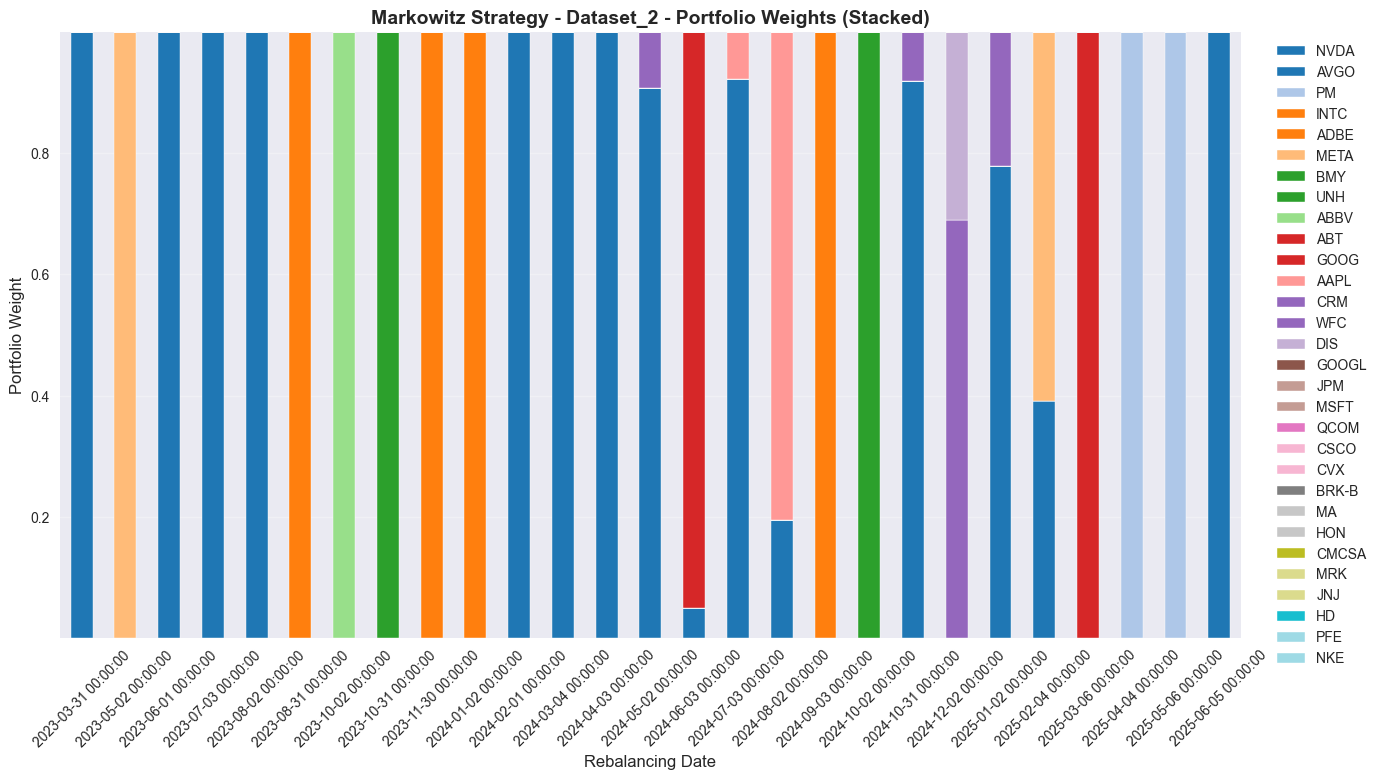


=== Markowitz Strategy - Top 30 Assets (Stacked) ===
NVDA    : Avg=0.3701  Max=1.0000  Min=0.0000
AVGO    : Avg=0.0804  Max=1.0000  Min=0.0000
PM      : Avg=0.0741  Max=1.0000  Min=0.0000
INTC    : Avg=0.0741  Max=1.0000  Min=0.0000
ADBE    : Avg=0.0741  Max=1.0000  Min=0.0000
META    : Avg=0.0596  Max=1.0000  Min=0.0000
BMY     : Avg=0.0370  Max=1.0000  Min=0.0000
UNH     : Avg=0.0370  Max=1.0000  Min=0.0000
ABBV    : Avg=0.0370  Max=1.0000  Min=0.0000
ABT     : Avg=0.0370  Max=1.0000  Min=0.0000
GOOG    : Avg=0.0352  Max=0.9507  Min=0.0000
AAPL    : Avg=0.0327  Max=0.8050  Min=0.0000
CRM     : Avg=0.0256  Max=0.6900  Min=0.0000
WFC     : Avg=0.0146  Max=0.2211  Min=0.0000
DIS     : Avg=0.0115  Max=0.3100  Min=0.0000
GOOGL   : Avg=0.0000  Max=0.0000  Min=0.0000
JPM     : Avg=0.0000  Max=0.0000  Min=0.0000
MSFT    : Avg=0.0000  Max=0.0000  Min=0.0000
QCOM    : Avg=0.0000  Max=0.0000  Min=0.0000
CSCO    : Avg=0.0000  Max=0.0000  Min=0.0000
CVX     : Avg=0.0000  Max=0.0000  Min=0.0000
B

In [23]:

strategy_name = "Markowitz"
dataset_num=2
# Test the visualization if we have weights data
if strategy_name in bt_backtest.results and f'dataset_{dataset_num}' in bt_backtest.results[strategy_name]:
    weights_data = bt_backtest.results[strategy_name][f'dataset_{dataset_num}'].get('weights_history', {})
    if len(weights_data.get('rebalancing_dates', [])) > 0:
        # Create stacked bar chart of top assets by average weight
        max_assets = 100
        all_assets = weights_data['asset_names'][0]
        # Build DataFrame: rows = rebalancing events, cols = assets
        weights_df = pd.DataFrame(list(weights_data['portfolio_weights']),
                      index=pd.to_datetime(weights_data['rebalancing_dates']),
                      columns=all_assets)
        
        # Select top assets by average weight
        avg_weights = weights_df.mean().sort_values(ascending=False)
        top_assets = list(avg_weights.head(max_assets).index)
        df_top = weights_df[top_assets]
        
        # Plot stacked bar chart
        ax = df_top.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='tab20')
        ax.set_title(f"{strategy_name} Strategy - Dataset_{dataset_num} - Portfolio Weights (Stacked)", fontsize=14, fontweight='bold')
        ax.set_xlabel("Rebalancing Date", fontsize=12)
        ax.set_ylabel("Portfolio Weight", fontsize=12)
        ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
        plt.xticks(rotation=45)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Print compact summary
        print(f"\n=== {strategy_name} Strategy - Top {len(top_assets)} Assets (Stacked) ===")
        for asset in top_assets:
            print(f"{asset:8s}: Avg={avg_weights[asset]:.4f}  Max={weights_df[asset].max():.4f}  Min={weights_df[asset].min():.4f}")
    else:
        print("No weights data available for visualization.")
else:
    print("No GMVP results available for visualization.")